# Imports

In [219]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from functions.epsilon_greedy_agent import get_action_epsilon_greedy
from functions.rewards import get_reward
from tqdm import tqdm
from functions.ucb_agent import train_ucb_agent_non_stat
from functions.epsilon_greedy_agent import train_agent_epsilon_greedy_non_stat

# Simulation parameters

In [66]:
# Fix the seed
np.random.seed(1)
# Number of agents
C_N_AGENTS = 2000
# Maximal time in s
C_T_MAX = 1000
# Learning-rate
C_LEARNING_RATE = 0.1
# Signal to Noise Ratio in dB
C_SNR_DB = 1
# Sampling frequency in Hz
C_SAMPLING_FREQ_HZ = 1
# Coherence time in s
C_COHERENCE_S = 60
# Power spread in dB
C_POWER_SPREAD = 20
# Bitrates in bits/s
C_BITRATES_BITS_PER_S =np.array([2520, 840, 360, 168])
# Warming time
C_WARMING_TIME_S = 50

# Non-stationary SNR and PER

In [67]:
def ar1_channel_power(P_avg_dB, sigma2_P_dB, tc, fs, D):
    n_tc = tc*fs
    phi = np.exp(-np.log(2)/n_tc)
    var_e = sigma2_P_dB*(1 - phi**2)
    
    C_NWARM = int(C_WARMING_TIME_S * fs)
    N = np.ceil(D*fs).astype(int)

    Y = np.zeros(C_NWARM + N)
    e = np.sqrt(var_e)*np.random.randn(C_NWARM + N)

    for k in range(1, C_NWARM + N):
        Y[k] = phi*Y[k-1] + e[k]

    P_dB = P_avg_dB + Y[C_NWARM:]

    return P_dB

In [68]:
# Get the SNR trajectory
v_snr = ar1_channel_power(C_SNR_DB, C_POWER_SPREAD, C_COHERENCE_S, C_SAMPLING_FREQ_HZ, C_T_MAX)

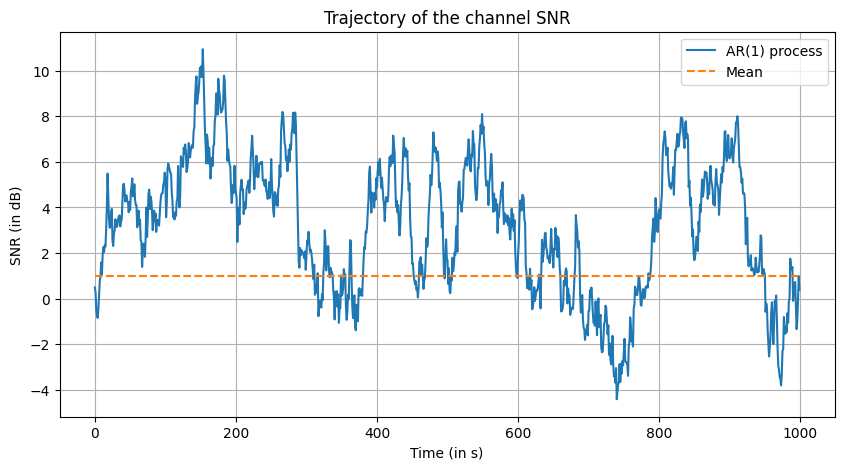

In [69]:
# Plot of the SNR trajectory
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(v_snr, label = "AR(1) process")
ax.plot(np.ones_like(v_snr) * C_SNR_DB, label = "Mean", linestyle = "dashed")
ax.set_xlabel('Time (in s)')
ax.set_ylabel('SNR (in dB)')
ax.set_title('Trajectory of the channel SNR')
ax.grid(True)
ax.legend()
plt.show()

# Interpolation of the PER curves on the SNR trajectory

In [70]:
def supposed(x , alpha, offset, factor, up):
    return factor*(((np.exp(-alpha*(x-offset)) - np.exp(alpha*(x-offset)))/(np.exp(-alpha*(x-offset)) + np.exp(alpha*(x-offset)))) + up)

def anal_estimation(supposed_general_form, x_data, y_data):
    popt, _ = curve_fit(supposed_general_form, x_data, y_data,bounds=([0,-20,0,0],[2,20,1,5]), maxfev=5000)
    alpha, offset, factor, up = popt
    
    def estimation(X):
        return supposed(X, alpha, offset, factor, up)
    
    return estimation

In [71]:
# Read the .csv file containing the PER
df = pd.read_csv('data/TEP_vs_SNR.csv')
labels = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"]

df_per = pd.DataFrame()
df_per['SNR'] = df.T.index[1:].astype(np.float32)
df_per['TEP_DSSS1'] = df.T[0].to_list()[1:]
df_per['TEP_DSSS3'] = df.T[1].to_list()[1:]
df_per['TEP_DSSS7'] = df.T[2].to_list()[1:]
df_per['TEP_DSSS15'] = df.T[3].to_list()[1:]


# Interpolation
f_DSSS1 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS1']))
f_DSSS3 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS3']))
f_DSSS7 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS7']))
f_DSSS15 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS15']))

# Compute the PER values for each modulation at each time
# using the interpolations
per_values = np.vstack((f_DSSS1(v_snr), f_DSSS3(v_snr), f_DSSS7(v_snr), f_DSSS15(v_snr))).T

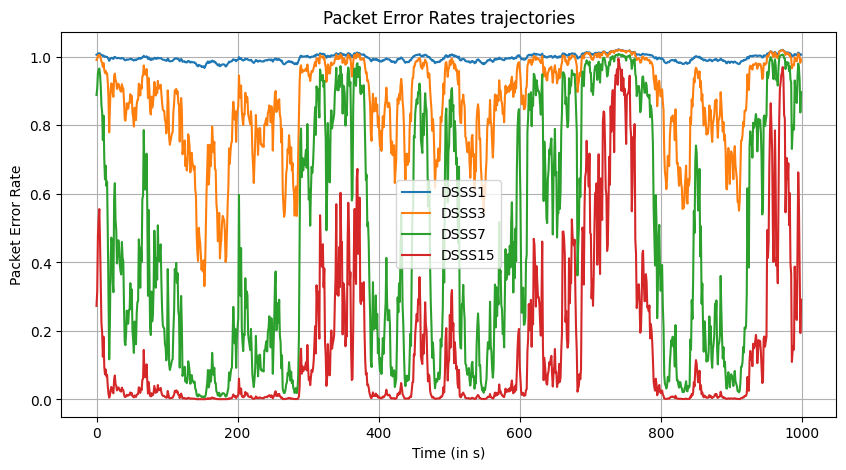

In [72]:
# Plot of the inteprolated PER curves
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(per_values, label = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"])
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Packet Error Rate')
ax.set_title('Packet Error Rates trajectories')
ax.grid(True)
ax.legend()
plt.show()

# Experiments on $\epsilon$-greedy and UCB agents

In [73]:
def train(n_iter, n_agents, alpha, eps, bitrates):
    k = bitrates.size
    action_values = np.zeros((n_iter, n_agents, k))
    action_counts = np.zeros((n_iter, n_agents, k))
    rewards = np.zeros((n_iter, n_agents))
    actions_chosen = np.zeros((n_iter, n_agents, k))

    for t in range(n_iter):
        snr = v_snr[t] # Current SNR
        per_values = np.array([f_DSSS1(snr), f_DSSS3(snr), f_DSSS7(snr), f_DSSS15(snr)])
   
        for agent in range(n_agents):
            action = get_action_epsilon_greedy(action_values[t, agent, :], eps)
            reward = get_reward(per_values, bitrates, action)
            action_counts[t + 1:, agent, action] = action_counts[t, agent, action] + 1
            action_values[t + 1:, agent, action] = action_values[t, agent, action] + alpha*(reward - action_values[t, agent, action])
            actions_chosen[t, agent, action] = 1
            rewards[t, agent] = reward
    return action_values, rewards, actions_chosen

### Experiment 1: Average cumulative reward for different values of $\alpha$

In [74]:
## Epsilon-greedy agent
# Epsilon value
eps = 0.129
# Alpha values
alpha = [1e-3, 1e-2, 0.1]
# Training
rewards_eps_greedy_1, _, _ = train_agent_epsilon_greedy_non_stat(per_values, C_BITRATES_BITS_PER_S, C_N_AGENTS, int(C_T_MAX * C_SAMPLING_FREQ_HZ), eps, alpha[0])
rewards_eps_greedy_2, _, _ = train_agent_epsilon_greedy_non_stat(per_values, C_BITRATES_BITS_PER_S, C_N_AGENTS, int(C_T_MAX * C_SAMPLING_FREQ_HZ), eps, alpha[1])
rewards_eps_greedy_3, _, _ = train_agent_epsilon_greedy_non_stat(per_values, C_BITRATES_BITS_PER_S, C_N_AGENTS, int(C_T_MAX * C_SAMPLING_FREQ_HZ), eps, alpha[2])

In [75]:
## UCB agent
rewards_ucb, action_values_ucb, action_counts_ucb = train_ucb_agent_non_stat(per_values, C_BITRATES_BITS_PER_S, C_N_AGENTS, int(C_T_MAX * C_SAMPLING_FREQ_HZ), 2, C_LEARNING_RATE)

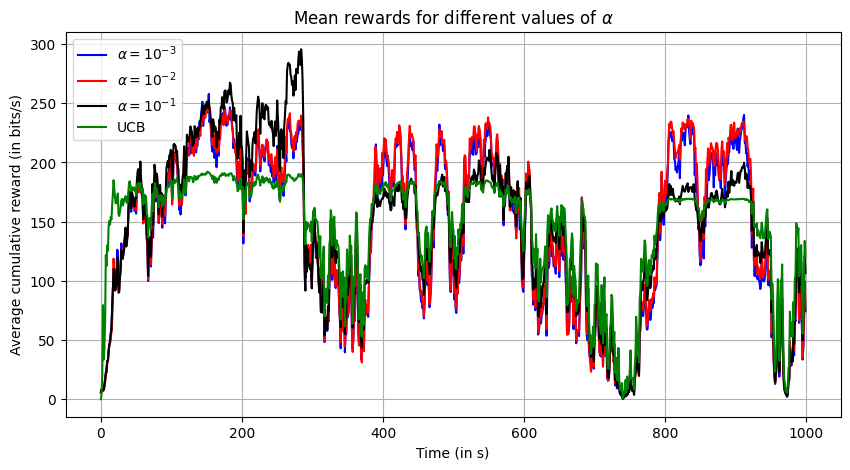

In [76]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(rewards_eps_greedy_1, axis=1), color='b', label=r'$\alpha=10^{-3}$')
ax.plot(np.mean(rewards_eps_greedy_2, axis=1), color='r', label=r'$\alpha=10^{-2}$')
ax.plot(np.mean(rewards_eps_greedy_3, axis=1), color='k', label=r'$\alpha=10^{-1}$')
ax.plot(np.mean(rewards_ucb, axis=1), color='g', label=r"UCB")
ax.grid(True)
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Average cumulative reward (in bits/s)')
ax.set_title(r'Mean rewards for different values of $\alpha$')
ax.legend()
plt.show()

### Experiment 2: Influence of $\varepsilon$ on the total reward

In [77]:
eps_values = np.linspace(0, 1, num=30)
alpha = 1e-1
total_rewards = list()

for eps in tqdm(eps_values):
    rewards, _, _ = train_agent_epsilon_greedy_non_stat(per_values, C_BITRATES_BITS_PER_S, C_N_AGENTS, int(C_T_MAX * C_SAMPLING_FREQ_HZ), eps, alpha)
    total_rewards.append(np.mean(rewards[-1, :]))

100%|██████████| 30/30 [16:01<00:00, 32.07s/it]


In [78]:
# Get the optimal epsilon values
eps_opt = eps_values[np.argmax(total_rewards)]

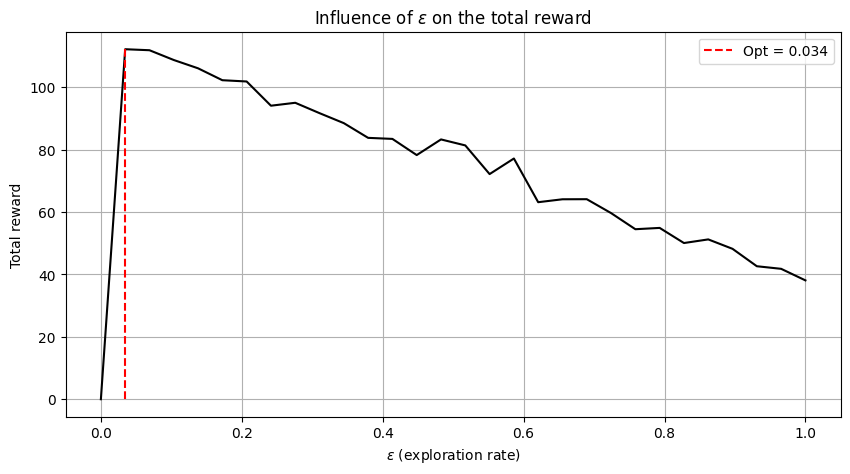

In [79]:
# Plot the 
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(eps_values, total_rewards, color='k')
ax.plot([eps_opt, eps_opt], [0, np.max(total_rewards)], color = 'r', label = f"Opt = {eps_opt:.3f}", linestyle = "dashed")
ax.grid(True)
ax.legend()
ax.set_xlabel(r'$\varepsilon$ (exploration rate)')
ax.set_ylabel('Total reward')
ax.set_title(r'Influence of $\varepsilon$ on the total reward')
plt.show()

### Experiment 3: Ratios of the chosen modulation methods and estimated Action-Values

In [80]:
# Training
rewards, actions_values, actions_chosen = train_agent_epsilon_greedy_non_stat(per_values, C_BITRATES_BITS_PER_S, C_N_AGENTS, int(C_T_MAX * C_SAMPLING_FREQ_HZ), eps_opt, C_LEARNING_RATE)

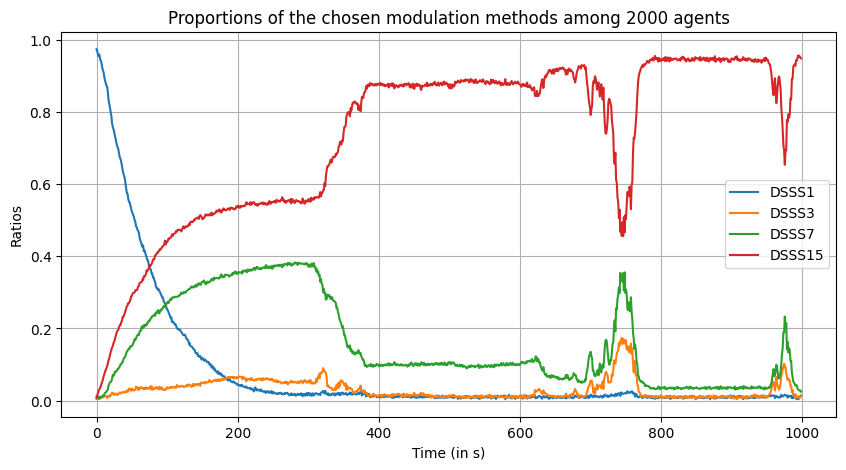

In [81]:
# Plot of the ratios
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(actions_chosen[1:, :, :] - actions_chosen[:-1, :, :], axis = 1), label=['DSSS1', 'DSSS3', 'DSSS7', 'DSSS15'])
ax.grid(True)
ax.legend()
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Ratios')
ax.set_title(f'Proportions of the chosen modulation methods among {C_N_AGENTS} agents')
plt.show()

Text(0, 0.5, 'Mean Action-Values (in bits/s)')

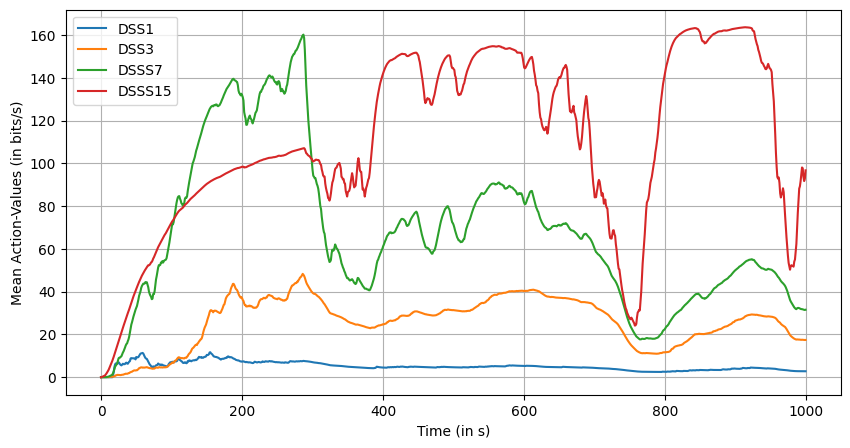

In [82]:
# Plot of the action values estimates
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(actions_values, axis = 1), label = ["DSS1", "DSS3", "DSSS7", "DSSS15"])
ax.grid()
ax.legend(loc = "best")
ax.set_xlabel("Time (in s)")
ax.set_ylabel("Mean Action-Values (in bits/s)")

Text(0.02, 0.5, "Agent's Action-Values")

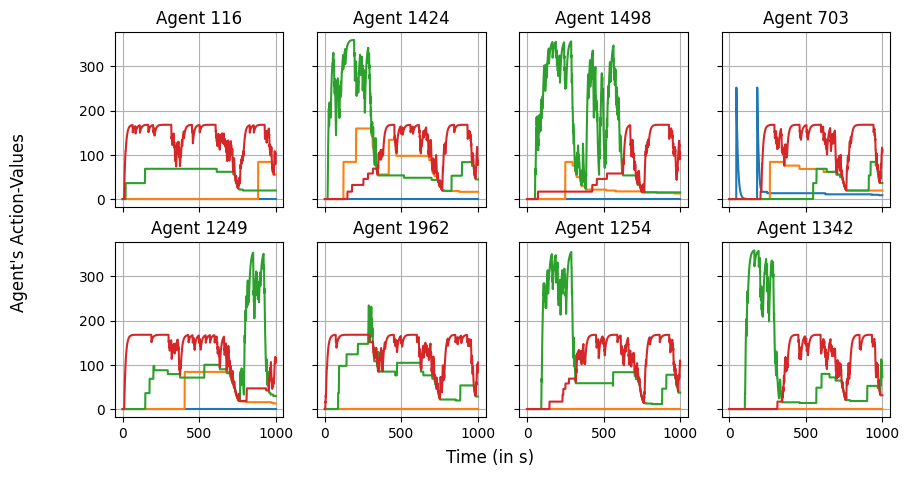

In [83]:
# Plot of multiple agents action-values
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5))
axs = axs.ravel()

for ax in axs :
    
    n_agent = np.random.randint(2000)
    ax.plot(actions_values[:, n_agent, :])
    ax.set_title(f"Agent {n_agent + 1}")
    ax.grid()


fig.supxlabel("Time (in s)")
fig.supylabel("Agent's Action-Values")

### New modulation schemes

In [220]:
def f_M1(snr):
    return 1/(1 + np.exp(0.2*snr))

def f_M2(snr):
    return 1/(1 + np.exp(1.5*snr))

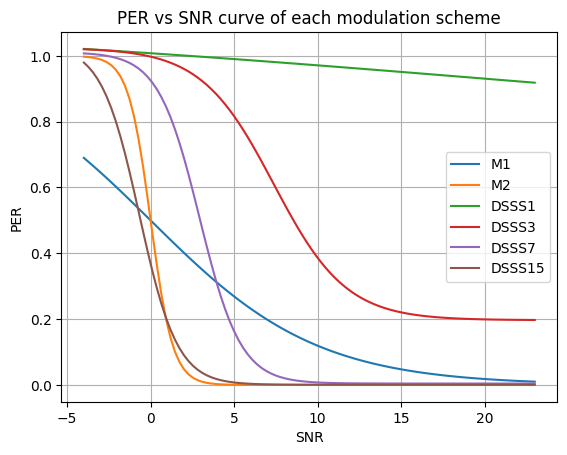

In [221]:
snr = np.linspace(-4, 23, num=100)
plt.plot(snr, f_M1(snr), label='M1')
plt.plot(snr, f_M2(snr), label='M2')
plt.plot(snr, f_DSSS1(snr), label='DSSS1')
plt.plot(snr, f_DSSS3(snr), label='DSSS3')
plt.plot(snr, f_DSSS7(snr), label='DSSS7')
plt.plot(snr, f_DSSS15(snr), label='DSSS15')
plt.xlabel('SNR')
plt.ylabel('PER')
plt.title('PER vs SNR curve of each modulation scheme')
plt.legend()
plt.grid(True)
plt.show()

In [222]:
# Fix the seed
np.random.seed(1)
# Number of agents
C_N_AGENTS = 2000
# Maximal time in s
C_T_MAX = 1000
# Learning-rate
C_LEARNING_RATE = 0.1
# Signal to Noise Ratio in dB
C_SNR_DB = 3
# Sampling frequency in Hz
C_SAMPLING_FREQ_HZ = 1
# Coherence time in s
C_COHERENCE_S = 60
# Power spread in dB
C_POWER_SPREAD = 10
# Bitrates in bits/s
C_BITRATES_BITS_PER_S = np.array([2520, 840, 360, 168, 250, 200])
# Warming time
C_WARMING_TIME_S = 50

In [223]:
v_snr = ar1_channel_power(C_SNR_DB, C_POWER_SPREAD, C_COHERENCE_S, C_SAMPLING_FREQ_HZ, C_T_MAX)
n_iter = v_snr.size

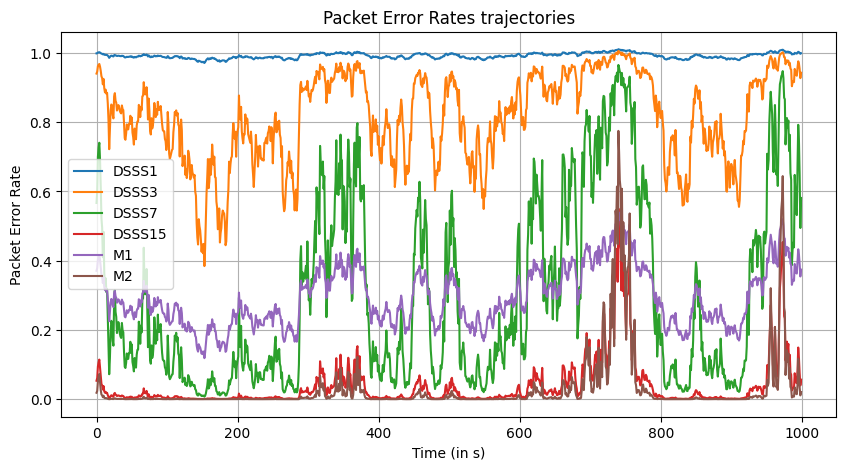

In [213]:
per_values = np.vstack((f_DSSS1(v_snr), f_DSSS3(v_snr), f_DSSS7(v_snr), f_DSSS15(v_snr), f_M1(v_snr), f_M2(v_snr))).T
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(per_values, label = ["DSSS1", "DSSS3", "DSSS7", "DSSS15", "M1", "M2"])
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Packet Error Rate')
ax.set_title('Packet Error Rates trajectories')
ax.grid(True)
ax.legend()
plt.show()

In [214]:
def train_new_modulations(n_iter, n_agents, alpha, eps, bitrates):
    k = bitrates.size
    action_values = np.zeros((n_iter, n_agents, k))
    action_counts = np.zeros((n_iter, n_agents, k))
    rewards = np.zeros((n_iter, n_agents))
    actions_chosen = np.zeros((n_iter, n_agents, k))

    for t in range(n_iter):
        snr = v_snr[t] # Current SNR
        per_values = np.array([f_DSSS1(snr), f_DSSS3(snr), f_DSSS7(snr), f_DSSS15(snr), f_M1(snr), f_M2(snr)])
   
        for agent in range(n_agents):
            action = get_action_epsilon_greedy(action_values[t, agent, :], eps)
            reward = get_reward(per_values, bitrates, action)
            action_counts[t + 1:, agent, action] = action_counts[t, agent, action] + 1
            action_values[t + 1:, agent, action] = action_values[t, agent, action] + alpha*(reward - action_values[t, agent, action])
            actions_chosen[t, agent, action] = 1
            rewards[t, agent] = reward
    return action_values, rewards, actions_chosen

In [215]:
eps = 0.05
alpha = [1e-3, 1e-2, 0.1]
_, rewards1, _ = train_new_modulations(n_iter, C_N_AGENTS, alpha[0], eps, C_BITRATES_BITS_PER_S)
_, rewards2, _ = train_new_modulations(n_iter, C_N_AGENTS, alpha[1], eps, C_BITRATES_BITS_PER_S)
_, rewards3, _ = train_new_modulations(n_iter, C_N_AGENTS, alpha[2], eps, C_BITRATES_BITS_PER_S)

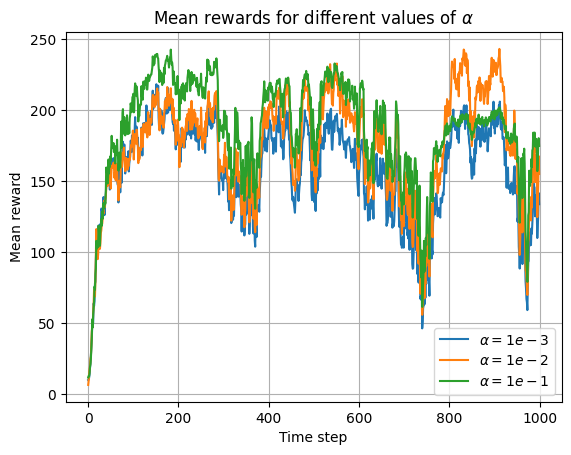

In [216]:
plt.plot(np.mean(rewards1, axis=1), label=r'$\alpha=1e-3$')
plt.plot(np.mean(rewards2, axis=1), label=r'$\alpha=1e-2$')
plt.plot(np.mean(rewards3, axis=1), label=r'$\alpha=1e-1$')
plt.title(r'Mean rewards for different values of $\alpha$')
plt.xlabel('Time step')
plt.ylabel('Mean reward')
plt.legend()
plt.grid(True)
plt.show()

In [217]:
_, _, actions_chosen = train_new_modulations(n_iter, C_N_AGENTS, 0.1, 0.05, C_BITRATES_BITS_PER_S)

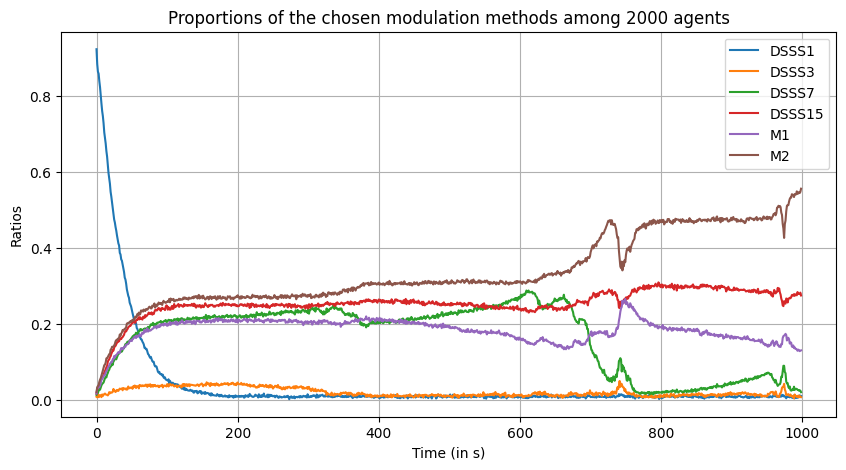

In [218]:
# Plot of the ratios
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(actions_chosen[1:, :, :], axis = 1), label=['DSSS1', 'DSSS3', 'DSSS7', 'DSSS15', 'M1', 'M2'])
ax.grid(True)
ax.legend()
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Ratios')
ax.set_title(f'Proportions of the chosen modulation methods among {C_N_AGENTS} agents')
plt.show()